## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Camera Calibration

In [29]:
import numpy as np
import pickle as pickle
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [10]:
# Read all the chessboard images in for camera calibration
filenames = []
for filename in glob.glob('camera_cal/calibration*'):
    filenames.append(filename)

In [11]:
# Number of Chessboard Corners
nx = 9
ny = 6

In [12]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

In [13]:
def camera_calibration(filename, nx=nx, ny=ny):
    '''Camera calibration to draw chessboard corners and append object(3D) and images(2D) points'''
    image = cv2.imread(filename)  # Read filename as image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Image to Grayscale
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)  # Corners Found
    if ret == True:  # If corners are found then draw corners
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        plt.figure()
        plt.imshow(image)
    else:
        print("Corners for {} not found".format(filename))

Corners for camera_cal/calibration4.jpg not found
Corners for camera_cal/calibration1.jpg not found
Corners for camera_cal/calibration5.jpg not found


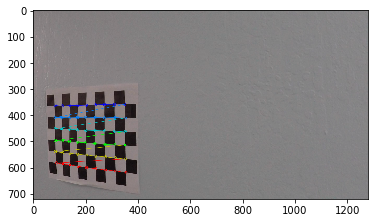

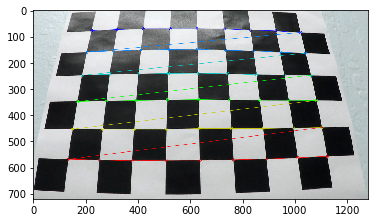

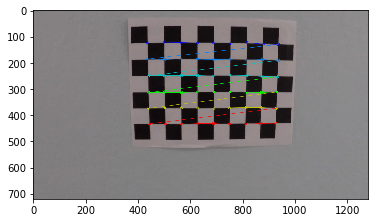

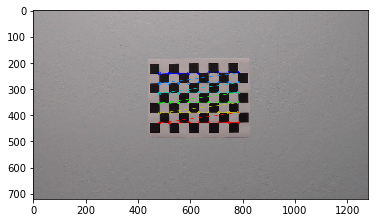

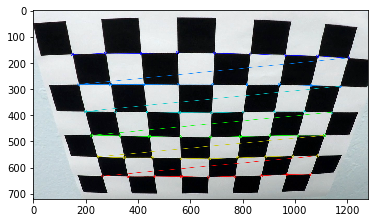

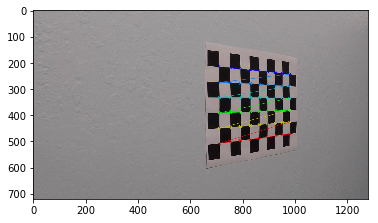

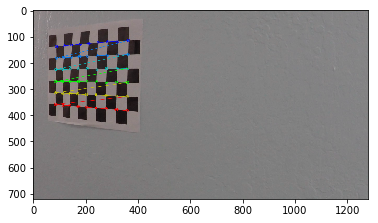

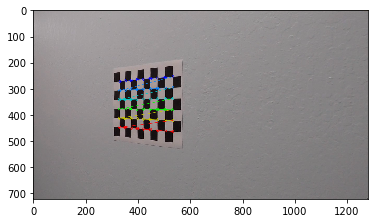

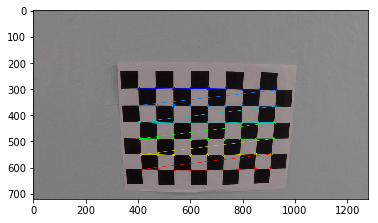

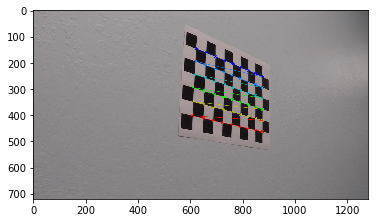

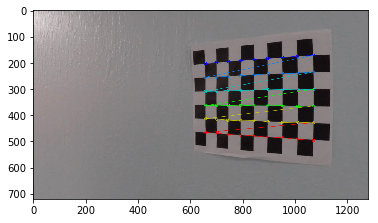

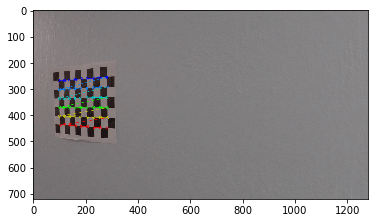

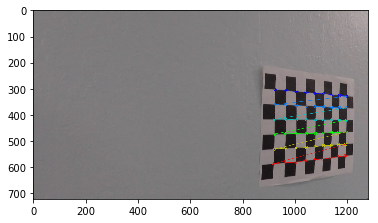

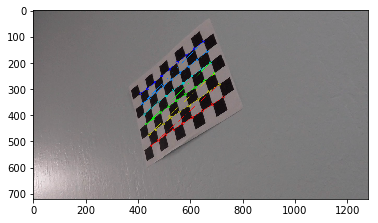

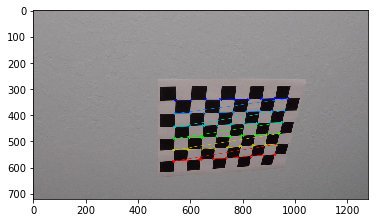

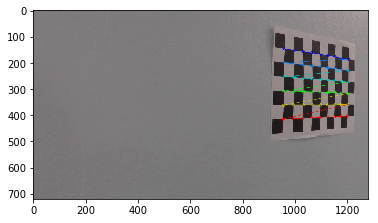

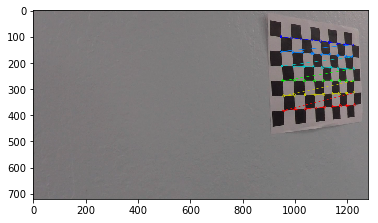

In [14]:
# Print Chessboard Corners for all filenames
for i in range(len(filenames)):
    camera_calibration(filenames[i])

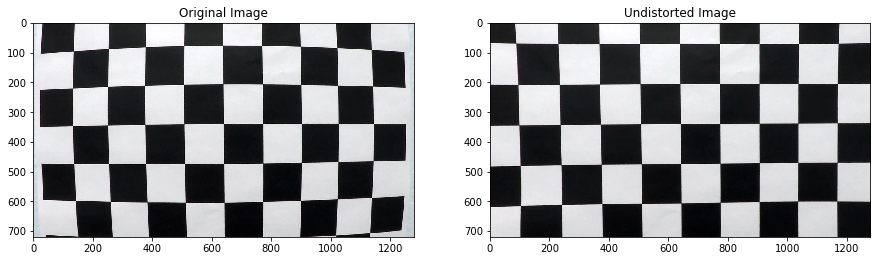

In [21]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])  # w x h

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(122)
plt.title("Undistorted Image")
plt.imshow(dst)
plt.show()

In [32]:
# Saved the value for mtx and dist in a pickle format
pickle.dump( { 'mtx': mtx, 'dist': dist }, open('./camera_cal/pickled_data/camera_calibration.p', 'wb'))

# Distortion Correction to Raw Images

In [33]:
raw_test_filenames = []
for test_filename in glob.glob('test_images/test*'):
    raw_test_filenames.append(test_filename)

In [34]:
print(raw_test_filenames)

['test_images/test1.jpg', 'test_images/test6.jpg', 'test_images/test4.jpg', 'test_images/test2.jpg', 'test_images/test5.jpg', 'test_images/test3.jpg']


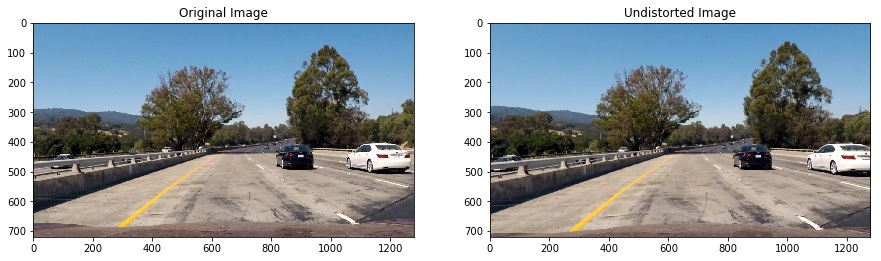

In [49]:
test_img = cv2.imread(raw_test_filenames[0])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_size = (test_img.shape[1], test_img.shape[0])  # w x h

test_dst = cv2.undistort(test_img, mtx, dist, None, mtx)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(test_img)
plt.subplot(122)
plt.title("Undistorted Image")
plt.imshow(test_dst)
plt.show()

Looking at the images above undistortion can be clearly be seen more on the edges of the images, i.e. Whole of the white car can be seen in the 'Original Image', whereas some of it has been cut out from 'Undistorted Image'.